In [1]:
import numpy as np
from numpy import zeros, ones
from numpy.random import randn, randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, LeakyReLU, Conv2DTranspose
from matplotlib import pyplot as plt

In [2]:
# Define the standalone discriminator model
def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [3]:
# Define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [4]:
# Define the combined generator and discriminator model
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [5]:
# Load and prepare CIFAR-10 training images
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    return X

In [6]:
# Select real samples
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

In [7]:
# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [8]:
# Use the generator to generate n fake examples
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

In [9]:
# Create and save a plot of generated images
def save_plot(examples, epoch, n=7):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i])
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [10]:
# Train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [11]:
# Evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [12]:
# Size of the latent space
latent_dim = 45

# Create the discriminator
d_model = define_discriminator()

# Create the generator
g_model = define_generator(latent_dim)

# Create the GAN
gan_model = define_gan(g_model, d_model)

# Load image data
dataset = load_real_samples()

# Train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 6ms/step
>4, 232/390, d1=0.568, d2=0.642 g=0.915
2/2 [==============================] - 0s 5ms/step
>4, 233/390, d1=0.523, d2=0.726 g=0.898
2/2 [==============================] - 0s 6ms/step
>4, 234/390, d1=0.498, d2=0.679 g=0.945
2/2 [==============================] - 0s 6ms/step
>4, 235/390, d1=0.581, d2=0.655 g=0.953
2/2 [==============================] - 0s 6ms/step
>4, 236/390, d1=0.579, d2=0.588 g=1.005
2/2 [==============================] - 0s 5ms/step
>4, 237/390, d1=0.482, d2=0.528 g=1.097
2/2 [==============================] - 0s 6ms/step
>4, 238/390, d1=0.581, d2=0.486 g=1.096
2/2 [==============================] - 0s 5ms/step
>4, 239/390, d1=0.583, d2=0.539 g=1.202
2/2 [==============================] - 0s 5ms/step
>4, 240/390, d1=0.570, d2=0.444 g=1.252
2/2 [==============================] - 0s 6ms/step
>4, 241/390, d1=0.528, d2=0.418 g=1.303
2/2 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>14, 232/390, d1=0.743, d2=0.593 g=0.966
2/2 [==============================] - 0s 5ms/step
>14, 233/390, d1=0.698, d2=0.639 g=1.050
2/2 [==============================] - 0s 5ms/step
>14, 234/390, d1=0.747, d2=0.548 g=0.980
2/2 [==============================] - 0s 5ms/step
>14, 235/390, d1=0.689, d2=0.645 g=0.909
2/2 [==============================] - 0s 5ms/step
>14, 236/390, d1=0.706, d2=0.630 g=0.892
2/2 [==============================] - 0s 5ms/step
>14, 237/390, d1=0.662, d2=0.590 g=0.856
2/2 [==============================] - 0s 5ms/step
>14, 238/390, d1=0.587, d2=0.641 g=0.869
2/2 [==============================] - 0s 5ms/step
>14, 239/390, d1=0.592, d2=0.665 g=0.866
2/2 [==============================] - 0s 5ms/step
>14, 240/390, d1=0.617, d2=0.670 g=0.837
2/2 [==============================] - 0s 9ms/step
>14, 241/390, d1=0.607, d2=0.740 g=0.917
2/2 [========================

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
>24, 232/390, d1=0.668, d2=0.720 g=0.822
2/2 [==============================] - 0s 5ms/step
>24, 233/390, d1=0.688, d2=0.658 g=0.843
2/2 [==============================] - 0s 6ms/step
>24, 234/390, d1=0.623, d2=0.644 g=0.845
2/2 [==============================] - 0s 5ms/step
>24, 235/390, d1=0.624, d2=0.623 g=0.858
2/2 [==============================] - 0s 5ms/step
>24, 236/390, d1=0.632, d2=0.639 g=0.868
2/2 [==============================] - 0s 4ms/step
>24, 237/390, d1=0.649, d2=0.617 g=0.867
2/2 [==============================] - 0s 4ms/step
>24, 238/390, d1=0.600, d2=0.641 g=0.885
2/2 [==============================] - 0s 6ms/step
>24, 239/390, d1=0.625, d2=0.622 g=0.891
2/2 [==============================] - 0s 6ms/step
>24, 240/390, d1=0.559, d2=0.644 g=0.891
2/2 [==============================] - 0s 6ms/step
>24, 241/390, d1=0.597, d2=0.653 g=0.915
2/2 [========================

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>34, 232/390, d1=0.623, d2=0.630 g=0.998
2/2 [==============================] - 0s 6ms/step
>34, 233/390, d1=0.722, d2=0.597 g=0.998
2/2 [==============================] - 0s 6ms/step
>34, 234/390, d1=0.751, d2=0.589 g=0.937
2/2 [==============================] - 0s 5ms/step
>34, 235/390, d1=0.678, d2=0.671 g=0.875
2/2 [==============================] - 0s 6ms/step
>34, 236/390, d1=0.610, d2=0.713 g=0.924
2/2 [==============================] - 0s 6ms/step
>34, 237/390, d1=0.656, d2=0.675 g=0.933
2/2 [==============================] - 0s 6ms/step
>34, 238/390, d1=0.657, d2=0.616 g=0.943
2/2 [==============================] - 0s 7ms/step
>34, 239/390, d1=0.659, d2=0.628 g=0.910
2/2 [==============================] - 0s 6ms/step
>34, 240/390, d1=0.673, d2=0.571 g=0.875
2/2 [==============================] - 0s 4ms/step
>34, 241/390, d1=0.615, d2=0.612 g=0.881
2/2 [========================

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>44, 232/390, d1=0.600, d2=0.621 g=0.867
2/2 [==============================] - 0s 7ms/step
>44, 233/390, d1=0.700, d2=0.607 g=0.893
2/2 [==============================] - 0s 5ms/step
>44, 234/390, d1=0.662, d2=0.589 g=0.941
2/2 [==============================] - 0s 5ms/step
>44, 235/390, d1=0.693, d2=0.615 g=0.921
2/2 [==============================] - 0s 7ms/step
>44, 236/390, d1=0.744, d2=0.597 g=0.903
2/2 [==============================] - 0s 5ms/step
>44, 237/390, d1=0.687, d2=0.637 g=0.884
2/2 [==============================] - 0s 4ms/step
>44, 238/390, d1=0.646, d2=0.625 g=0.833
2/2 [==============================] - 0s 5ms/step
>44, 239/390, d1=0.639, d2=0.650 g=0.819
2/2 [==============================] - 0s 6ms/step
>44, 240/390, d1=0.631, d2=0.759 g=0.854
2/2 [==============================] - 0s 5ms/step
>44, 241/390, d1=0.621, d2=0.598 g=0.862
2/2 [========================

1/1 [==============================] - 0s 23ms/step


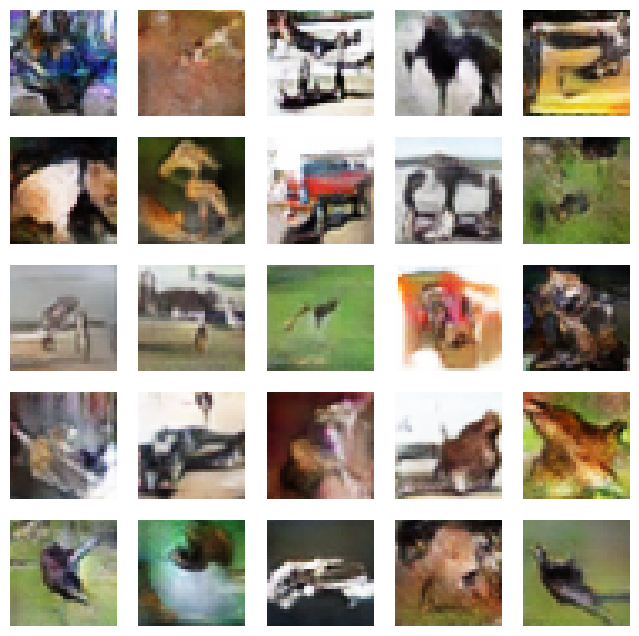

In [15]:
n_samples_to_display = 25
latent_points_to_display = generate_latent_points(latent_dim, n_samples_to_display)
generated_images = g_model.predict(latent_points_to_display)

generated_images = (generated_images + 1) / 2.0

plt.figure(figsize=(8, 8))
for i in range(n_samples_to_display):
    plt.subplot(5, 5, i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.show()